# RNA Structure Benchmark Preprocessing & Utilities

This notebook:

1. Converts **ArchiveII** `.bpseq` files → `sequence, dot_bracket` CSV  
2. Converts **bpRNA-NF-15.0** raw CSV → the same format  
3. Implements encoding utilities (sequence & dot-bracket)  
4. Implements PyTorch Dataset classes + collate function  
5. Implements Nussinov dynamic programming decoder  
6. Runs sanity checks on both datasets


In [2]:
#Import necessary libraries
import os
import glob
from typing import List, Tuple
from numba import njit
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

print("PyTorch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


PyTorch version: 2.9.1+cpu


'cpu'

In [3]:
from pathlib import Path

# This notebook lives in project_root/notebooks
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"

print("Notebook dir:", NOTEBOOK_DIR)
print("Project root:", PROJECT_ROOT)
print("Data dir:", DATA_DIR)


Notebook dir: c:\Fall_2025\CSE6301\Project\rna-structural-prediction\notebooks
Project root: c:\Fall_2025\CSE6301\Project\rna-structural-prediction
Data dir: c:\Fall_2025\CSE6301\Project\rna-structural-prediction\data


## 1. ArchiveII – BPSEQ → Standardized CSV

We know the BPSEQ files are in:

`data/archiveII/raw/archiveII_bpseq/archiveII_bpseq/`

We will parse all `.bpseq` files, extract:

- `sequence_id` – file name without extension  
- `sequence` – RNA sequence (T converted to U)  
- `dot_bracket` – structure inferred from BPSEQ pairs  

and save to:

`data/archiveII/processed/archiveII_from_bpseq.csv`


In [4]:
# Set up ArchiveII BPSEQ paths (relative to this notebook's working directory)
archive_bpseq_dir = DATA_DIR / "archiveII" / "raw" / "archiveII_bpseq" / "archiveII_bpseq"
archive_processed_dir = DATA_DIR / "archiveII" / "processed"
archive_processed_dir.mkdir(parents=True, exist_ok=True)

archiveii_csv_path = archive_processed_dir / "archiveII_from_bpseq.csv"

archive_bpseq_dir, archive_processed_dir, archiveii_csv_path


(WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/archiveII/raw/archiveII_bpseq/archiveII_bpseq'),
 WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/archiveII/processed'),
 WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/archiveII/processed/archiveII_from_bpseq.csv'))

In [5]:
def parse_bpseq_file(bpseq_path: str) -> Tuple[str, str]:
    """
    Parse a BPSEQ file and return (sequence, dot_bracket).

    BPSEQ format (typical):
        index  base  pair_index
    - index: 1-based position
    - base:  single character (A,C,G,U/T,...)
    - pair_index: 1-based index of paired position, 0 or -1 if unpaired.
    """
    indices = []
    bases = []
    partners = []

    with open(bpseq_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("#") or line.startswith(";"):
                continue

            parts = line.split()
            if len(parts) < 3:
                continue

            idx = int(parts[0])
            base = parts[1]
            pair_idx = int(parts[2])

            indices.append(idx)
            bases.append(base)
            partners.append(pair_idx)

    # sort by index just in case
    order = sorted(range(len(indices)), key=lambda k: indices[k])
    bases = [bases[i] for i in order]
    partners = [partners[i] for i in order]

    L = len(bases)

    # Build list of base pairs (0-based)
    pairs: List[Tuple[int, int]] = []
    for i in range(L):
        p = partners[i]
        if p <= 0:
            continue
        j = p - 1  # convert to 0-based
        if j > i:
            pairs.append((i, j))

    # Convert to dot-bracket
    chars = ["."] * L
    for i, j in pairs:
        chars[i] = "("
        chars[j] = ")"
    dot_bracket = "".join(chars)

    # Normalize sequence: T -> U
    seq = "".join(bases).upper().replace("T", "U")

    return seq, dot_bracket


In [6]:
bpseq_files = list(archive_bpseq_dir.glob("*.bpseq"))
print(f"Found {len(bpseq_files)} BPSEQ files in {archive_bpseq_dir}")

archive_records = []

for path in bpseq_files:
    fname = path.name
    seq_id = os.path.splitext(fname)[0]

    seq, db = parse_bpseq_file(path)

    if len(seq) != len(db):
        print(
            f"WARNING: length mismatch in {fname}: "
            f"len(seq)={len(seq)}, len(dot_bracket)={len(db)}"
        )

    archive_records.append(
        {
            "sequence_id": seq_id,
            "sequence": seq,
            "dot_bracket": db,
        }
    )

archiveii_df = pd.DataFrame(archive_records)
archiveii_df.to_csv(archiveii_csv_path, index=False)

print("ArchiveII standardized CSV saved to:", archiveii_csv_path)
archiveii_df.head()


Found 3975 BPSEQ files in c:\Fall_2025\CSE6301\Project\rna-structural-prediction\data\archiveII\raw\archiveII_bpseq\archiveII_bpseq
ArchiveII standardized CSV saved to: c:\Fall_2025\CSE6301\Project\rna-structural-prediction\data\archiveII\processed\archiveII_from_bpseq.csv


,sequence_id,sequence,dot_bracket
0,16s_A.fulgidus,AUUCUGGUUGAUCCUGCCAGAGGCCGCUGCUAUCCGGCUGGGACUA...,...(((((...(((.))))).((((((((((.((((((((((.......
1,16s_A.fulgidus_domain1,AUUCUGGUUGAUCCUGCCAGAGGCCGCUGCUAUCCGGCUGGGACUA...,...(((((.......))))).((((((((((.((((((((((.......
2,16s_A.fulgidus_domain2,UUUAUUGGGCCUAAAGCGUCCGUAGCCGGGCUGGUAAGUCCUCCGG...,.......(((((...(.((((.(.(((.(((((((.((((((((((...
3,16s_A.fulgidus_domain3,AAGGAAUUGGCGGGGGAGCACUACAACGGGUGGAGCCUGCGGUUUA...,.......(((((.(((((((..((..((((((.((((((((((......
4,16s_A.fulgidus_domain4,ACCGCCCGUCAAGCCACCCGAGUGGGCCAGGGGCGAGGGGGUGGCC...,.(.(..((...((((.(((..(((((((..((((..((((((((((...


## 2. bpRNA-NF-15.0 – Raw CSV → Standardized CSV

Raw file path (you may have both absolute and relative):

- Absolute (Windows, from your system):  
  `C:\Fall_2025\CSE6301\Project\rna-structural-prediction\data\bprna_nf15\raw\bpRNA-NF-15.0.csv`

We’ll also define a **relative path** so the notebook is portable:

`data/bprna_nf15/raw/bpRNA-NF-15.0.csv`

We will inspect its columns, then map:

- `sequence_id`
- `sequence`
- `dot_bracket`

into:

`data/bprna_nf15/processed/bprna_nf15_standardized.csv`


In [7]:
# Relative to project root (data is sibling of notebooks)
bprna_raw_csv = DATA_DIR / "bprna_nf15" / "raw" / "bpRNA-NF-15.0.csv"

bprna_processed_dir = DATA_DIR / "bprna_nf15" / "processed"
bprna_processed_dir.mkdir(parents=True, exist_ok=True)

bprna_processed_csv = bprna_processed_dir / "bprna_nf15_standardized.csv"

bprna_raw_csv, bprna_processed_csv


(WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/bprna_nf15/raw/bpRNA-NF-15.0.csv'),
 WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/bprna_nf15/processed/bprna_nf15_standardized.csv'))

In [8]:
bprna_df_raw = pd.read_csv(bprna_raw_csv)

print("bpRNA-NF-15.0 raw shape:", bprna_df_raw.shape)
print("Columns:", list(bprna_df_raw.columns))
bprna_df_raw.head()


bpRNA-NF-15.0 raw shape: (8788, 3)
Columns: ['rna_name', 'seq', 'struct']


,rna_name,seq,struct
0,CP002582.1/3780440-3780356,UUAAUGAGAAUAAAUCAGGUUAUUAUGUUGGAUGUAAUAACUGGGC...,.........[[[...[.((((((((((.....))))))))))..((...
1,CP001997.1/495019-495096,UCCUUACAAGAUCAGGCGGCUUUUAGUGCGGCCGGGCCUCUUUUGA...,.......[[[..[.(((.((.....))...)))..(((((....))...
2,CP002028.1/1768652-1768573,AAAGCAUAAUGGAUCAGGUAGAACGGAAAAGUUUUACCGGGCUCUU...,........[[[[..[.((((((((......))))))))..((((.....
3,AAWL01000017.1/25112-25035,AUAAUACAACAGGAACAGGCGGCUGCCGCGAGGCAGUGCAGCCGGG...,.........[[[[..[.(((.((((((....))))))...)))..(...
4,ADLR01000090.1/3100-3003,AUAUGAUACAGUGAGCAGGCGACGGCCGAAAUGAGAAUCGUCGCCG...,.........[.[[..[.((((((((............))))))))....


In [9]:
# TODO: adjust these three names to match actual column names in bpRNA-NF-15.0.csv
# Common patterns: 'sequence', 'str', 'structure', 'dot_bracket', etc.
seq_col = "seq"   # <-- change if different
db_col = "struct"   # <-- change if different
id_col = "rna_name"          # <-- change if different; or we create synthetic IDs

# If the ID column doesn't exist, create a synthetic one
if id_col not in bprna_df_raw.columns:
    print(f"Column '{id_col}' not found; creating synthetic sequence_id.")
    bprna_df_raw["sequence_id"] = [f"bprna_{i}" for i in range(len(bprna_df_raw))]
    id_col = "sequence_id"

# Normalize sequences: T -> U
bprna_df_raw[seq_col] = bprna_df_raw[seq_col].astype(str).str.upper().str.replace("T", "U")

bprna_df = pd.DataFrame(
    {
        "sequence_id": bprna_df_raw[id_col].astype(str),
        "sequence": bprna_df_raw[seq_col].astype(str),
        "dot_bracket": bprna_df_raw[db_col].astype(str),
    }
)

len_mismatch = (bprna_df["sequence"].str.len() != bprna_df["dot_bracket"].str.len()).sum()
print("Standardized bpRNA shape:", bprna_df.shape)
print("Length mismatches:", len_mismatch)

bprna_df.head()


Standardized bpRNA shape: (8788, 3)
Length mismatches: 0


,sequence_id,sequence,dot_bracket
0,CP002582.1/3780440-3780356,UUAAUGAGAAUAAAUCAGGUUAUUAUGUUGGAUGUAAUAACUGGGC...,.........[[[...[.((((((((((.....))))))))))..((...
1,CP001997.1/495019-495096,UCCUUACAAGAUCAGGCGGCUUUUAGUGCGGCCGGGCCUCUUUUGA...,.......[[[..[.(((.((.....))...)))..(((((....))...
2,CP002028.1/1768652-1768573,AAAGCAUAAUGGAUCAGGUAGAACGGAAAAGUUUUACCGGGCUCUU...,........[[[[..[.((((((((......))))))))..((((.....
3,AAWL01000017.1/25112-25035,AUAAUACAACAGGAACAGGCGGCUGCCGCGAGGCAGUGCAGCCGGG...,.........[[[[..[.(((.((((((....))))))...)))..(...
4,ADLR01000090.1/3100-3003,AUAUGAUACAGUGAGCAGGCGACGGCCGAAAUGAGAAUCGUCGCCG...,.........[.[[..[.((((((((............))))))))....


In [10]:
bprna_df.to_csv(bprna_processed_csv, index=False)
print("Standardized bpRNA CSV saved to:", bprna_processed_csv)

Standardized bpRNA CSV saved to: c:\Fall_2025\CSE6301\Project\rna-structural-prediction\data\bprna_nf15\processed\bprna_nf15_standardized.csv


## 3. Encoding Utilities

We now define:

- `encode_sequence(seq)` → integer IDs (A/C/G/U)
- `dotbracket_to_pairs(dot_bracket)` → list of base pairs
- `pairs_to_matrix(pairs, length)` → L×L numpy matrix
- `dotbracket_to_matrix(dot_bracket)` → convenience wrapper


In [11]:
# Basic RNA vocabulary
BASE2IDX = {"A": 0, "C": 1, "G": 2, "U": 3}


def encode_sequence(seq: str) -> torch.Tensor:
    """
    Encode an RNA sequence to integer IDs.
    - Upper-case
    - Convert T->U
    - Unknown bases -> 0 (A)
    """
    seq = seq.upper().replace("T", "U")
    idxs = [BASE2IDX.get(b, 0) for b in seq]
    return torch.tensor(idxs, dtype=torch.long)


def dotbracket_to_pairs(dot_bracket: str) -> List[Tuple[int, int]]:
    """
    Convert dot-bracket string to base-pair list (i, j), 0-based.
    Assumes non-pseudoknotted structures using '(' and ')'.
    """
    stack = []
    pairs = []
    for i, ch in enumerate(dot_bracket):
        if ch == "(":
            stack.append(i)
        elif ch == ")":
            if not stack:
                raise ValueError(f"Unmatched ')' at position {i} in {dot_bracket}")
            j = stack.pop()
            pairs.append((j, i))
        # '.' etc. = unpaired

    if stack:
        raise ValueError(f"Unmatched '(' in dot-bracket: {dot_bracket}")

    return pairs


def pairs_to_matrix(pairs: List[Tuple[int, int]], length: int) -> np.ndarray:
    """
    Convert base-pair list to symmetric L×L matrix.
    """
    mat = np.zeros((length, length), dtype=np.float32)
    for i, j in pairs:
        if 0 <= i < length and 0 <= j < length:
            mat[i, j] = 1.0
            mat[j, i] = 1.0
    return mat


def dotbracket_to_matrix(dot_bracket: str) -> np.ndarray:
    """
    dot-bracket → base-pair list → L×L matrix
    """
    L = len(dot_bracket)
    pairs = dotbracket_to_pairs(dot_bracket)
    return pairs_to_matrix(pairs, L)


In [12]:
seq_test = "GCAUCU"
db_test = "..(..)"

print("Sequence:", seq_test)
print("Dot-bracket:", db_test)

encoded = encode_sequence(seq_test)
pairs = dotbracket_to_pairs(db_test)
mat = dotbracket_to_matrix(db_test)

print("Encoded:", encoded)
print("Pairs:", pairs)
print("Matrix:\n", mat)


Sequence: GCAUCU
Dot-bracket: ..(..)
Encoded: tensor([2, 1, 0, 3, 1, 3])
Pairs: [(2, 5)]
Matrix:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


## 4. PyTorch Datasets and Collate Function

We define:

- `ArchiveIIDataset` – loads `archiveII_from_bpseq.csv`
- `BpRNANFDataset` – loads `bprna_nf15_standardized.csv`
- `collate_rna_batch` – pads sequences and matrices into batched tensors


In [13]:
class ArchiveIIDataset(Dataset):
    """
    ArchiveII dataset from standardized CSV with columns:
      - sequence_id
      - sequence
      - dot_bracket
    """
    def __init__(self, csv_path: str):
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        required = {"sequence", "dot_bracket"}
        if not required.issubset(self.df.columns):
            raise ValueError(f"Missing required columns {required} in {csv_path}")

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        seq = str(row["sequence"])
        db = str(row["dot_bracket"])
        mat = torch.from_numpy(dotbracket_to_matrix(db))  # (L, L)
        return seq, mat


class BpRNANFDataset(Dataset):
    """
    bpRNA-NF-15.0 dataset from standardized CSV with columns:
      - sequence_id
      - sequence
      - dot_bracket
    """
    def __init__(self, csv_path: str):
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        required = {"sequence", "dot_bracket"}
        if not required.issubset(self.df.columns):
            raise ValueError(f"Missing required columns {required} in {csv_path}")

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        seq = str(row["sequence"])
        db = str(row["dot_bracket"])
        mat = torch.from_numpy(dotbracket_to_matrix(db))
        return seq, mat


def collate_rna_batch(batch):
    """
    Collate function for variable-length RNA sequences.

    batch: list of (sequence_str, basepair_matrix_tensor (L, L))

    Returns:
      input_ids: (B, Lmax) int64
      mask:      (B, Lmax) bool (True = valid token)
      targets:   (B, Lmax, Lmax) float32
    """
    seqs, mats = zip(*batch)
    lengths = [len(s) for s in seqs]
    Lmax = max(lengths)
    B = len(seqs)

    input_ids = torch.zeros((B, Lmax), dtype=torch.long)
    mask = torch.zeros((B, Lmax), dtype=torch.bool)
    targets = torch.zeros((B, Lmax, Lmax), dtype=torch.float32)

    for i, (seq, mat) in enumerate(zip(seqs, mats)):
        L = len(seq)
        input_ids[i, :L] = encode_sequence(seq)
        mask[i, :L] = True
        targets[i, :L, :L] = mat

    return input_ids, mask, targets


In [14]:
# Paths to standardized CSVs we created earlier
archiveii_csv_path = archiveii_csv_path  # from Cell 4
bprna_processed_csv = bprna_processed_csv  # from Cell 8/11

arch_dataset = ArchiveIIDataset(archiveii_csv_path)
bprna_dataset = BpRNANFDataset(bprna_processed_csv)

print("ArchiveII dataset size:", len(arch_dataset))
print("bpRNA dataset size:", len(bprna_dataset))

arch_loader = DataLoader(arch_dataset, batch_size=4, shuffle=True, collate_fn=collate_rna_batch)

input_ids, mask, targets = next(iter(arch_loader))
print("input_ids shape:", input_ids.shape)
print("mask shape:", mask.shape)
print("targets shape:", targets.shape)


ArchiveII dataset size: 3975
bpRNA dataset size: 8788
input_ids shape: torch.Size([4, 123])
mask shape: torch.Size([4, 123])
targets shape: torch.Size([4, 123, 123])


In [15]:
# Use the full processed datasets for Nussinov evaluation
arch_eval_subset = arch_dataset      # full ArchiveII
bprna_eval_subset = bprna_dataset    # full bpRNA-NF

print("ArchiveII eval size:", len(arch_eval_subset))
print("bpRNA eval size:", len(bprna_eval_subset))


ArchiveII eval size: 3975
bpRNA eval size: 8788


## 5. Nussinov Dynamic Programming Decoder

We implement:

- `nussinov_from_sequence(seq)` – classic DP maximizing number of base pairs  
- `nussinov_from_scores(seq, score_matrix)` – future use with neural model scores  


In [16]:
def can_pair(b1: str, b2: str) -> bool:
    """
    Canonical base-pairing rules (Watson-Crick + wobble).
    """
    pair = {b1 + b2, b2 + b1}
    return bool(pair & {"AU", "UA", "GC", "CG", "GU", "UG"})


def nussinov_dp(seq: str, scores: np.ndarray | None = None) -> np.ndarray:
    """
    Nussinov DP to maximize total pairing score.

    If scores is None, each valid pair scores 1.0.
    Otherwise, scores[i, j] is used for base pair (i, j).
    """
    L = len(seq)
    dp = np.zeros((L, L), dtype=np.float32)

    for length in range(1, L):  # j - i
        for i in range(L - length):
            j = i + length

            # Case 1: i unpaired
            best = dp[i + 1, j]

            # Case 2: j unpaired
            best = max(best, dp[i, j - 1])

            # Case 3: i paired with j
            if can_pair(seq[i], seq[j]):
                pair_score = 1.0 if scores is None else scores[i, j]
                best = max(best, dp[i + 1, j - 1] + pair_score)

            # Case 4: bifurcation
            for k in range(i + 1, j):
                best = max(best, dp[i, k] + dp[k + 1, j])

            dp[i, j] = best

    return dp


def nussinov_traceback(
    seq: str, dp: np.ndarray, scores: np.ndarray | None, i: int, j: int, pairs: List[Tuple[int, int]]
):
    """
    Traceback to recover optimal base pairs from DP table.
    """
    if i >= j:
        return

    if dp[i, j] == dp[i + 1, j]:
        nussinov_traceback(seq, dp, scores, i + 1, j, pairs)
    elif dp[i, j] == dp[i, j - 1]:
        nussinov_traceback(seq, dp, scores, i, j - 1, pairs)
    elif can_pair(seq[i], seq[j]):
        pair_score = 1.0 if scores is None else scores[i, j]
        if dp[i, j] == dp[i + 1, j - 1] + pair_score:
            pairs.append((i, j))
            nussinov_traceback(seq, dp, scores, i + 1, j - 1, pairs)
        else:
            for k in range(i + 1, j):
                if dp[i, j] == dp[i, k] + dp[k + 1, j]:
                    nussinov_traceback(seq, dp, scores, i, k, pairs)
                    nussinov_traceback(seq, dp, scores, k + 1, j, pairs)
                    break
    else:
        for k in range(i + 1, j):
            if dp[i, j] == dp[i, k] + dp[k + 1, j]:
                nussinov_traceback(seq, dp, scores, i, k, pairs)
                nussinov_traceback(seq, dp, scores, k + 1, j, pairs)
                break


def pairs_to_dotbracket(pairs: List[Tuple[int, int]], length: int) -> str:
    chars = ["."] * length
    for i, j in pairs:
        chars[i] = "("
        chars[j] = ")"
    return "".join(chars)


def nussinov_from_sequence(seq: str) -> str:
    """
    Classic Nussinov: each valid base pair = 1.
    """
    L = len(seq)
    if L == 0:
        return ""
    dp = nussinov_dp(seq, scores=None)
    pairs: List[Tuple[int, int]] = []
    nussinov_traceback(seq, dp, scores=None, i=0, j=L - 1, pairs=pairs)
    return pairs_to_dotbracket(pairs, L)


def nussinov_from_scores(seq: str, score_matrix: np.ndarray) -> str:
    """
    Nussinov decoding using model-provided score matrix.
    """
    L = len(seq)
    assert score_matrix.shape == (L, L)
    dp = nussinov_dp(seq, scores=score_matrix)
    pairs: List[Tuple[int, int]] = []
    nussinov_traceback(seq, dp, scores=score_matrix, i=0, j=L - 1, pairs=pairs)
    return pairs_to_dotbracket(pairs, L)


In [17]:
# === Numba-accelerated Nussinov DP ===

# 0:A, 1:C, 2:G, 3:U
@njit
def _can_pair_codes(b1, b2):
    # A-U / U-A
    if (b1 == 0 and b2 == 3) or (b1 == 3 and b2 == 0):
        return True
    # C-G / G-C
    if (b1 == 1 and b2 == 2) or (b1 == 2 and b2 == 1):
        return True
    # G-U / U-G (wobble)
    if (b1 == 2 and b2 == 3) or (b1 == 3 and b2 == 2):
        return True
    return False


@njit
def _nussinov_dp_core(codes):
    """
    Numba core: codes is an int8 array of length L with:
      0:A, 1:C, 2:G, 3:U
    Returns an L x L float32 DP matrix.
    """
    L = len(codes)
    dp = np.zeros((L, L), dtype=np.float32)
    min_loop = 0  # you can change to 3 if you want a minimum hairpin loop length

    for span in range(1, L):
        for i in range(L - span):
            j = i + span

            # Case 1: i unpaired
            best = dp[i + 1, j]

            # Case 2: j unpaired
            if dp[i, j - 1] > best:
                best = dp[i, j - 1]

            # Case 3: i paired with j
            if j - i > min_loop and _can_pair_codes(codes[i], codes[j]):
                val = dp[i + 1, j - 1] + 1.0
                if val > best:
                    best = val

            # Case 4: bifurcation
            for k in range(i + 1, j):
                val = dp[i, k] + dp[k + 1, j]
                if val > best:
                    best = val

            dp[i, j] = best

    return dp


def nussinov_dp_numba(seq: str) -> np.ndarray:
    """
    Wrapper: converts sequence string -> code array -> Numba DP.
    """
    seq_u = seq.upper().replace("T", "U")
    L = len(seq_u)
    codes = np.empty(L, dtype=np.int8)

    for i, ch in enumerate(seq_u):
        if ch == "A":
            codes[i] = 0
        elif ch == "C":
            codes[i] = 1
        elif ch == "G":
            codes[i] = 2
        elif ch == "U":
            codes[i] = 3
        else:
            # Unknown → treat as A (won't pair with much)
            codes[i] = 0

    return _nussinov_dp_core(codes)


# Override the old Python-only nussinov_from_sequence to use the Numba DP
def nussinov_from_sequence(seq: str) -> str:
    """
    Nussinov decoding using Numba-accelerated DP.
    """
    L = len(seq)
    dp = nussinov_dp_numba(seq)

    # Reuse your existing Python traceback + dot-bracket helpers
    pairs: List[Tuple[int, int]] = []
    nussinov_traceback(seq, dp, scores=None, i=0, j=L - 1, pairs=pairs)
    return pairs_to_dotbracket(pairs, L)


In [18]:
# Take first ArchiveII sequence and run Nussinov baseline
seq0, true_mat0 = arch_dataset[0]
pred_db0 = nussinov_from_sequence(seq0)

print("Sequence ID 0 length:", len(seq0))
print("Sequence 0:", seq0[:80] + ("..." if len(seq0) > 80 else ""))
print("Nussinov predicted structure (first 80 chars):", pred_db0[:80] + ("..." if len(pred_db0) > 80 else ""))

# Compare predicted structure matrix with true matrix shape
pred_pairs0 = dotbracket_to_pairs(pred_db0)
pred_mat0 = pairs_to_matrix(pred_pairs0, len(seq0))

print("True matrix shape:", true_mat0.shape)
print("Pred matrix shape:", pred_mat0.shape)


Sequence ID 0 length: 1492
Sequence 0: AUUCUGGUUGAUCCUGCCAGAGGCCGCUGCUAUCCGGCUGGGACUAAGCCAUGCGAGUCAAGGGGCUUGUAUCCCUUCGG...
Nussinov predicted structure (first 80 chars): .(((())(())((((()(.)((()()))()(()(())(())(((().()(()()).))))))))()((((()(((((())...
True matrix shape: torch.Size([1492, 1492])
Pred matrix shape: (1492, 1492)


In [19]:
def compare_pair_matrices(true_mat, pred_mat):
    """
    Computes pair-level TP, FP, FN, Precision, Recall, F1.

    Inputs:
      true_mat: torch.Tensor or numpy array (L, L)
      pred_mat: same shape

    Returns:
      dictionary of metrics
    """
    # Convert to torch tensors
    if not isinstance(true_mat, torch.Tensor):
        true_mat = torch.tensor(true_mat)
    if not isinstance(pred_mat, torch.Tensor):
        pred_mat = torch.tensor(pred_mat)

    # Only upper triangle is needed (avoid counting (i,j) and (j,i) twice)
    triu = torch.triu(torch.ones_like(true_mat), diagonal=1).bool()

    true_pairs = true_mat.bool() & triu
    pred_pairs = pred_mat.bool() & triu

    TP = (true_pairs & pred_pairs).sum().item()
    FP = ((~true_pairs) & pred_pairs).sum().item()
    FN = (true_pairs & (~pred_pairs)).sum().item()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2*TP / (2*TP + FP + FN) if (2*TP + FP + FN) > 0 else 0.0

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
    }


In [20]:
def run_nussinov_eval_on_subset(subset, name="dataset"):
    """
    Run Nussinov on every sequence in the given subset and collect metrics.

    subset: torch.utils.data.Subset (or any Dataset with __getitem__ -> (seq, true_mat))
    name:   label for logging

    Returns:
      metrics_df: pandas DataFrame with one row per sequence
    """
    records = []
    n = len(subset)
    print(f"Running Nussinov on {n} sequences from {name}...")

    for i in range(n):
        seq, true_mat = subset[i]   # seq: str, true_mat: torch.Tensor (L, L)
        L = len(seq)

        # Run Nussinov
        pred_db = nussinov_from_sequence(seq)
        pred_pairs = dotbracket_to_pairs(pred_db) if "(" in pred_db or ")" in pred_db else []
        pred_mat = pairs_to_matrix(pred_pairs, L)
        pred_mat_t = torch.tensor(pred_mat, dtype=torch.float32)

        # Compute metrics
        metrics = compare_pair_matrices(true_mat, pred_mat_t)
        metrics["seq_len"] = L
        metrics["index"] = i

        records.append(metrics)

        if (i + 1) % 20 == 0 or (i + 1) == n:
            print(f"  Done {i+1}/{n}")

    df = pd.DataFrame(records)
    print(f"\n{name} Nussinov summary:")
    print(df[["Precision", "Recall", "F1"]].describe())
    return df


In [21]:
# Nussinov evaluation on ArchiveII eval subset
arch_nussinov_df = run_nussinov_eval_on_subset(arch_eval_subset, name="ArchiveII")

# Nussinov evaluation on bpRNA eval subset
bprna_nussinov_df = run_nussinov_eval_on_subset(bprna_eval_subset, name="bpRNA-NF-15.0")


Running Nussinov on 3975 sequences from ArchiveII...
  Done 20/3975
  Done 40/3975
  Done 60/3975
  Done 80/3975
  Done 100/3975
  Done 120/3975
  Done 140/3975
  Done 160/3975
  Done 180/3975
  Done 200/3975
  Done 220/3975
  Done 240/3975
  Done 260/3975
  Done 280/3975
  Done 300/3975
  Done 320/3975
  Done 340/3975
  Done 360/3975
  Done 380/3975
  Done 400/3975
  Done 420/3975
  Done 440/3975
  Done 460/3975
  Done 480/3975
  Done 500/3975
  Done 520/3975
  Done 540/3975
  Done 560/3975
  Done 580/3975
  Done 600/3975
  Done 620/3975
  Done 640/3975
  Done 660/3975
  Done 680/3975
  Done 700/3975
  Done 720/3975
  Done 740/3975
  Done 760/3975
  Done 780/3975
  Done 800/3975
  Done 820/3975
  Done 840/3975
  Done 860/3975
  Done 880/3975
  Done 900/3975
  Done 920/3975
  Done 940/3975
  Done 960/3975
  Done 980/3975
  Done 1000/3975
  Done 1020/3975
  Done 1040/3975
  Done 1060/3975
  Done 1080/3975
  Done 1100/3975
  Done 1120/3975
  Done 1140/3975
  Done 1160/3975
  Done 1180/39

In [22]:
from pathlib import Path

results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

arch_nussinov_df.to_csv(results_dir / "archiveII_nussinov_eval.csv", index=False)
bprna_nussinov_df.to_csv(results_dir / "bprna_nussinov_eval.csv", index=False)

print("Saved Nussinov evaluation CSVs in", results_dir)


Saved Nussinov evaluation CSVs in ..\results


## Plotting the evaluation results

In [24]:
import matplotlib.pyplot as plt


In [39]:
arch_nussinov_df.columns.tolist()


['TP', 'FP', 'FN', 'Precision', 'Recall', 'F1', 'seq_len', 'index']

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def _find_col(df, target_name):
    """
    Find column whose name matches target_name case-insensitively.
    Returns the actual column name or None.
    """
    target = target_name.lower()
    for c in df.columns:
        if c.lower() == target:
            return c
    return None


def get_precision_recall_arrays(df):
    """
    Return (precision, recall) arrays for the DataFrame.

    Uses explicit precision/recall columns if present.
    Otherwise computes from TP/FP/FN columns.
    """
    # 1) Try explicit precision / recall columns
    p_col = _find_col(df, "precision")
    r_col = _find_col(df, "recall")

    if p_col is not None and r_col is not None:
        precision = df[p_col].astype(float).to_numpy()
        recall = df[r_col].astype(float).to_numpy()
        return precision, recall

    # 2) Fallback: compute from TP/FP/FN
    tp_col = _find_col(df, "tp")
    fp_col = _find_col(df, "fp")
    fn_col = _find_col(df, "fn")

    if tp_col is None or fp_col is None or fn_col is None:
        raise ValueError(
            "Could not find precision/recall or TP/FP/FN columns in DataFrame. "
            f"Available columns: {list(df.columns)}"
        )

    TP = df[tp_col].astype(float).to_numpy()
    FP = df[fp_col].astype(float).to_numpy()
    FN = df[fn_col].astype(float).to_numpy()

    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    return precision, recall


def micro_pr(df):
    """
    Micro-averaged precision/recall using TP/FP/FN (any casing).
    """
    tp_col = _find_col(df, "tp")
    fp_col = _find_col(df, "fp")
    fn_col = _find_col(df, "fn")

    if tp_col is None or fp_col is None or fn_col is None:
        raise ValueError(
            "Could not find TP/FP/FN columns in DataFrame for micro-PR. "
            f"Available columns: {list(df.columns)}"
        )

    TP = df[tp_col].sum()
    FP = df[fp_col].sum()
    FN = df[fn_col].sum()

    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    return precision, recall


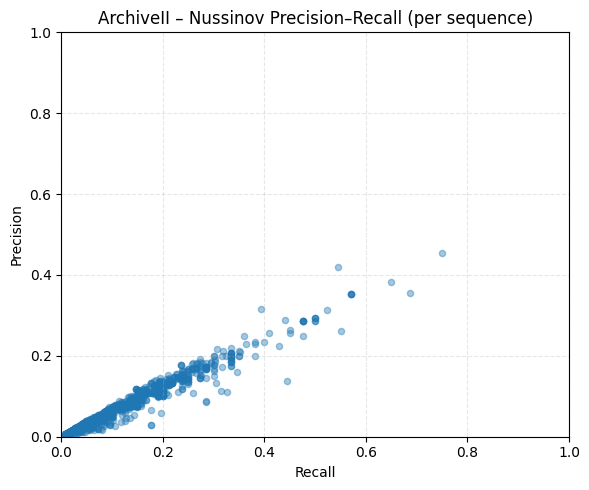

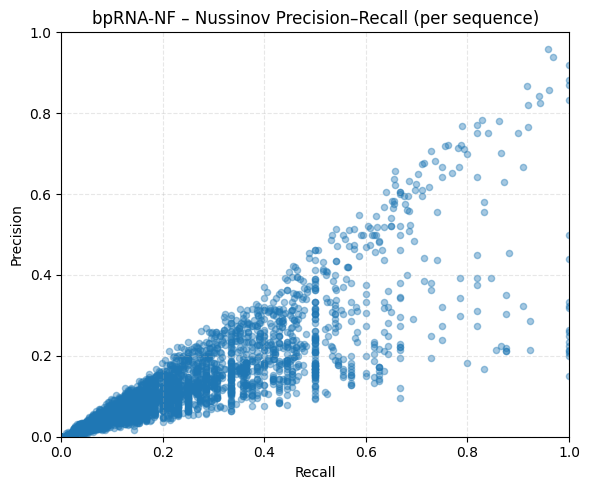

In [36]:
def plot_precision_recall_scatter(df, title):
    precision, recall = get_precision_recall_arrays(df)

    plt.figure(figsize=(6, 5))
    plt.scatter(recall, precision, alpha=0.4, s=20)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_precision_recall_scatter(
    arch_nussinov_df,
    "ArchiveII – Nussinov Precision–Recall (per sequence)"
)
plot_precision_recall_scatter(
    bprna_nussinov_df,
    "bpRNA-NF – Nussinov Precision–Recall (per sequence)"
)


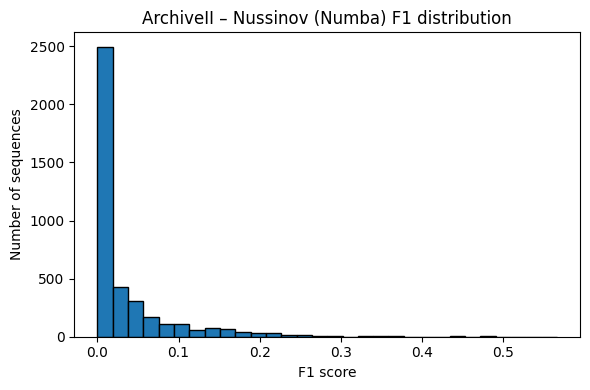

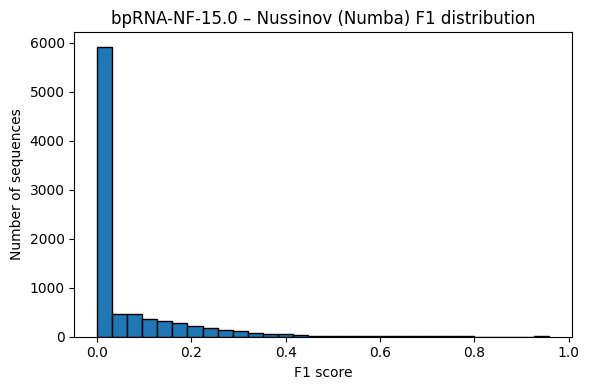

In [25]:
import matplotlib.pyplot as plt

def plot_f1_hist(df, title):
    plt.figure(figsize=(6, 4))
    plt.hist(df["F1"].values, bins=30, edgecolor="black")
    plt.xlabel("F1 score")
    plt.ylabel("Number of sequences")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_f1_hist(arch_nussinov_df, "ArchiveII – Nussinov (Numba) F1 distribution")
plot_f1_hist(bprna_nussinov_df, "bpRNA-NF-15.0 – Nussinov (Numba) F1 distribution")


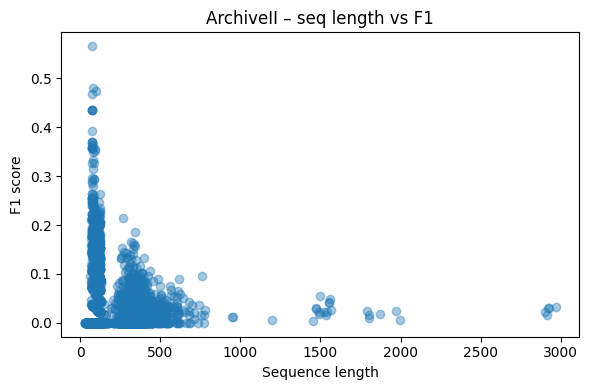

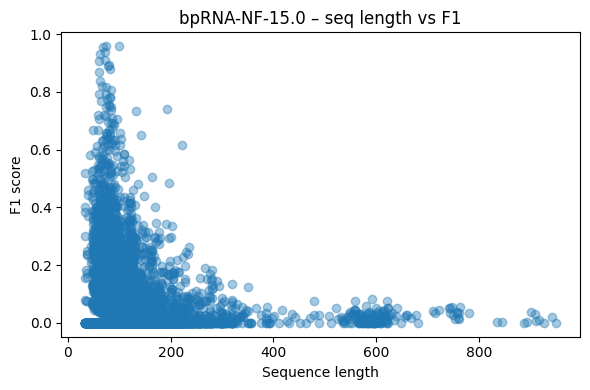

In [26]:
def plot_len_vs_f1(df, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(df["seq_len"].values, df["F1"].values, alpha=0.4)
    plt.xlabel("Sequence length")
    plt.ylabel("F1 score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_len_vs_f1(arch_nussinov_df, "ArchiveII – seq length vs F1")
plot_len_vs_f1(bprna_nussinov_df, "bpRNA-NF-15.0 – seq length vs F1")


In [28]:
def micro_pr(df):
    """Compute micro-averaged precision and recall."""
    TP = df["TP"].sum()
    FP = df["FP"].sum()
    FN = df["FN"].sum()
    
    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    return precision, recall


micro_prec_arch, micro_rec_arch = micro_pr(arch_nussinov_df)
micro_prec_bp, micro_rec_bp     = micro_pr(bprna_nussinov_df)

print("ArchiveII Micro-Precision:", micro_prec_arch)
print("ArchiveII Micro-Recall:", micro_rec_arch)
print("bpRNA Micro-Precision:", micro_prec_bp)
print("bpRNA Micro-Recall:", micro_rec_bp)


ArchiveII Micro-Precision: 0.02199600263689387
ArchiveII Micro-Recall: 0.03562677602137166
bpRNA Micro-Precision: 0.04168220945221705
bpRNA Micro-Recall: 0.09109766102691862


ArchiveII Micro-Precision: 0.02199600263689387
ArchiveII Micro-Recall   : 0.03562677602137166
bpRNA Micro-Precision    : 0.04168220945221705
bpRNA Micro-Recall       : 0.09109766102691862


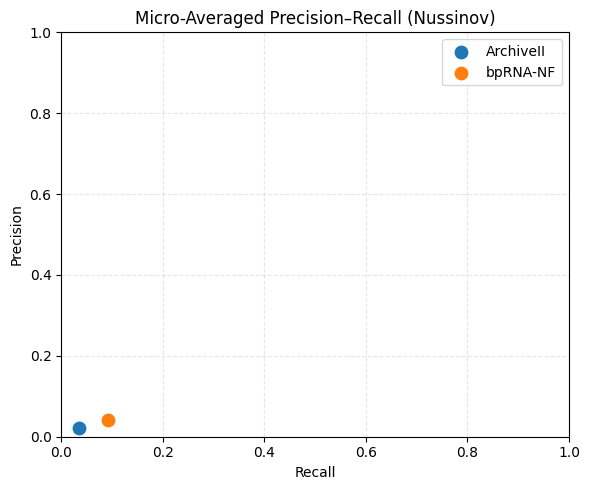

In [37]:
micro_prec_arch, micro_rec_arch = micro_pr(arch_nussinov_df)
micro_prec_bp, micro_rec_bp     = micro_pr(bprna_nussinov_df)

print("ArchiveII Micro-Precision:", micro_prec_arch)
print("ArchiveII Micro-Recall   :", micro_rec_arch)
print("bpRNA Micro-Precision    :", micro_prec_bp)
print("bpRNA Micro-Recall       :", micro_rec_bp)


def plot_micro_pr_points(arch_prec, arch_rec, bp_prec, bp_rec):
    plt.figure(figsize=(6, 5))
    plt.scatter(arch_rec, arch_prec, s=80, label="ArchiveII")
    plt.scatter(bp_rec,  bp_prec,  s=80, label="bpRNA-NF")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Micro-Averaged Precision–Recall (Nussinov)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_micro_pr_points(
    micro_prec_arch, micro_rec_arch,
    micro_prec_bp,   micro_rec_bp
)


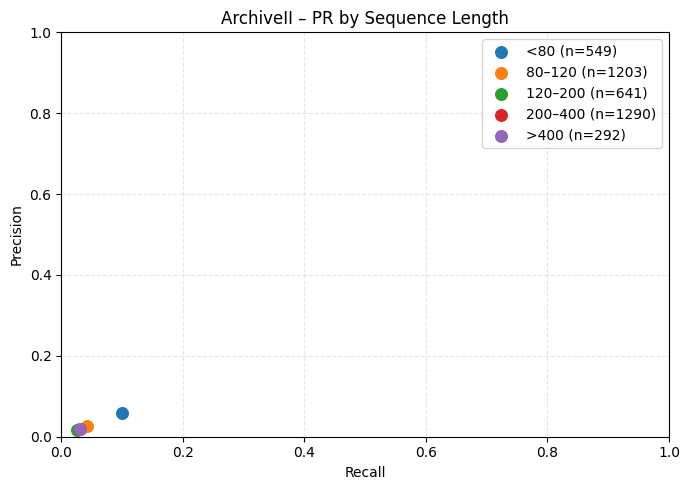

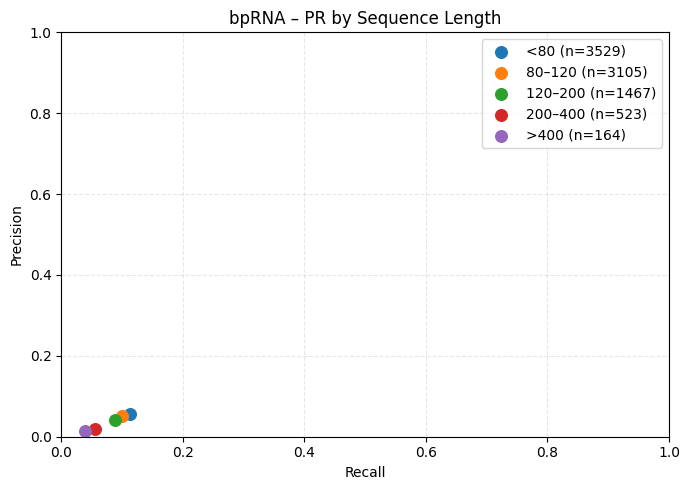

In [30]:
import numpy as np

def plot_pr_by_length(df, title):
    bins = [0, 80, 120, 200, 400, 10000]
    labels = ["<80", "80–120", "120–200", "200–400", ">400"]

    plt.figure(figsize=(7, 5))

    for i in range(len(bins)-1):
        lo, hi = bins[i], bins[i+1]
        subset = df[(df["seq_len"] >= lo) & (df["seq_len"] < hi)]
        if len(subset) == 0:
            continue
        p, r = micro_pr(subset)
        plt.scatter(r, p, s=70, label=f"{labels[i]} (n={len(subset)})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_pr_by_length(arch_nussinov_df, "ArchiveII – PR by Sequence Length")
plot_pr_by_length(bprna_nussinov_df, "bpRNA – PR by Sequence Length")
